# RGR Stock Price Forecasting Project - Part 7

Author: Jack Wang

---

## Problem Statement

Stock prices are hard to predict because they are not only affected by the performance of the underlying companies but also the expectations from the general public. As known, the stock price of firearm companies are highly correlated to the public opinions toward gun control. My model intends to predict the stock price of one of the largest firearm company in the states, RGR (Sturm, Ruger & Co., firearm company), by using its historical stock price, public opinions toward gun control, and its financial reports to SEC. 

## Executive Summary

The goal of my projcet is to build a **time series regression model** that predicts the stock price of RGR. The data I am using would be historical stock price from [Yahoo Finance](https://finance.yahoo.com/quote/RGR/history?p=RGR), twitter posts scraped from [twitter](https://twitter.com/), subreddit posts mentioned about gun control, and also the financial reports to [SEC](https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0000095029&type=&dateb=&owner=exclude&count=100). I will do sentiment analysis on the text data and time series modeling on the historical stock price data. The model will be evaluated using MSE.

## Content

This project consists of 7 Jupyter notebooks:
- Part-1-stock-price-data
- Part-2-twitter-scraper
- Part-3-twitter-data-cleaning
- Part-4-reddit-data-scraper
- Part-5-reddit-data-cleaning
- Part-6-sec-data-cleaning
- ***Part-7-modeling-and-evaluation***


---


In [461]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import itertools
import pickle

from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model

%matplotlib inline

plt.style.use('fivethirtyeight')

/Users/jackwang/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
df_twitter = pd.read_csv("../data/twitter/twitter.csv")
df_reddit = pd.read_csv("../data/reddit/reddit.csv")
df_sec = pd.read_csv("../data/sec/sec_data.csv")
df_rgr = pd.read_csv("../data/stock_price/stock_price_2014_to_2019.csv")

In [4]:
# Format RGR dataset
df_rgr = df_rgr.loc[:,['Date', 'Open']]
df_rgr.columns = ['date', 'open_price']
df_rgr = df_rgr.iloc[693:1446].reset_index(drop=True)

# Merge all dataset
df_final = pd.merge(df_rgr, df_twitter, how='outer')
df_final = pd.merge(df_final, df_reddit, how = 'outer')
df_final = pd.merge(df_final, df_sec, how = 'outer' )

# Formatting and filling N/A
df_final['date'] = pd.to_datetime(df_final['date'])
df_final = df_final.set_index('date')
df_final = df_final.sort_index()
df_final = df_final.fillna(0)
df_final = df_final[df_final['open_price']!=0]

df_final.head()

,open_price,tweet_word_count_sum,tweet_compound_score_sum,tweets_sum,tweet_word_count_mean,tweet_compound_score_mean,redd_gun_score_mean,redd_gun_comment_mean,redd_gun_compound_mean,redd_gun_score_sum,...,redd_gun_post_count,redd_pol_score_mean,redd_pol_comment_mean,redd_pol_compound_mean,redd_pol_score_sum,redd_pol_comment_sum,redd_pol_post_count,10-k,10-q,8-k
date,,,,,,,,,,,,,,,,,,,,,
2016-10-03,57.790001,18548,-401.5402,1133,16.370697,-0.354404,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-04,57.470001,16554,-356.2059,1017,16.277286,-0.350252,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-05,57.330002,19727,-338.7394,1194,16.521776,-0.283701,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-06,56.400002,12924,-220.6480,807,16.014870,-0.273418,0.0,7.0,-0.7184,0.0,...,1.0,2.0,5.0,-0.1958,4.0,10.0,2.0,0.0,0.0,0.0
2016-10-07,56.020000,9767,-210.2939,613,15.933116,-0.343057,1.0,1.0,-0.1280,1.0,...,1.0,0.0,3.0,0.3612,0.0,3.0,1.0,0.0,0.0,0.0


In [5]:
df_final.to_csv("../data/final.csv",index=False)

**GrideSearch over SARIMA**

In [6]:
train = df_final['2016':'2019-8']
test = df_final['2019-9':]

In [7]:
p = d = q = range(0, 2)
s = range(5,7)
pdq = list(itertools.product(p, d, q))
pdqs = list(itertools.product(p, d, q, s))
seasonal_pdqs = [(x[0], x[1], x[2], x[3]) for x in pdqs]

In [ ]:
best_aic = 10000
best_param = (0, 0, 0)
best_param_season = (0, 0, 0, 0)

for param in pdq:
    for param_seasonal in seasonal_pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train['open_price'],
                                            train.drop(columns='open_price'),
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            current_aic = results.aic
            if current_aic < best_aic:
                best_aic = current_aic
                best_param = param
                best_param_season = param_seasonal
            print('ARIMA{}x{} - AIC: {}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [8]:
print(f'Best AIC score is: {best_aic}')
print(f'ARIMA params is: {best_param}')
print(f'SARIMA param is: {best_param_season}')

NameError: name 'best_aic' is not defined

In [9]:
mod = sm.tsa.statespace.SARIMAX(endog=train['open_price'],
                                exog=train.drop(columns='open_price'),
                                order=(0, 1, 1),
                                seasonal_order=(0, 0, 1, 6),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [10]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                        open_price   No. Observations:                  733
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 6)   Log Likelihood               -1099.578
Date:                           Wed, 04 Dec 2019   AIC                           2245.155
Time:                                   16:08:54   BIC                           2350.606
Sample:                                        0   HQIC                          2285.854
                                           - 733                                         
Covariance Type:                             opg                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
tweet_word_count_sum      -1.144e-08   1.42e-06     -0.008      0.994    -2.8e-06    2.78e-06
tweet_compound_score_sum     -0.0001      0.000     -0.380      0.704      -0.001       0.000
tweets_sum                -1.978e-05      0.000     -0.185      0.853      -0.000       0.000
tweet_word_count_mean        -0.0281      0.061     -0.463      0.644      -0.147       0.091
tweet_compound_score_mean     0.9575      1.237      0.774      0.439      -1.467       3.382
redd_gun_score_mean           0.0018      0.005      0.383      0.701      -0.007       0.011
redd_gun_comment_mean         0.0652      0.022      2.996      0.003       0.023       0.108
redd_gun_compound_mean        0.4096      0.270      1.515      0.130      -0.120       0.940
redd_gun_score_sum            0.0069      0.002      3.013      0.003       0.002       0.011
redd_gun_comment_sum         -0.0765      0.020     -3.785      0.000      -0.116      -0.037
redd_gun_post_count           0.2708      0.118      2.303      0.021       0.040       0.501
redd_pol_score_mean          -0.0003      0.000     -1.149      0.250      -0.001       0.000
redd_pol_comment_mean         0.0013      0.001      1.501      0.133      -0.000       0.003
redd_pol_compound_mean        0.0316      0.133      0.238      0.812      -0.229       0.292
redd_pol_score_sum         5.538e-05   2.99e-05      1.853      0.064   -3.18e-06       0.000
redd_pol_comment_sum         -0.0004      0.000     -1.785      0.074      -0.001    3.81e-05
redd_pol_post_count          -0.0064      0.015     -0.419      0.675      -0.036       0.023
10-k                         -0.4347      0.470     -0.925      0.355      -1.356       0.486
10-q                          1.4728      0.179      8.221      0.000       1.122       1.824
8-k                           0.0504      0.115      0.437      0.662      -0.176       0.277
ma.L1                         0.0523      0.033      1.608      0.108      -0.011       0.116
ma.S.L6                      -0.0121      0.043     -0.283      0.777      -0.096       0.072
sigma2                        1.2187      0.035     34.378      0.000       1.149       1.288
===================================================================================
Ljung-Box (Q):                       44.37   Jarque-Bera (JB):              1725.85
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**As we can see, the p-value for all features are pretty high. We can conclude this model is performing poorly.**

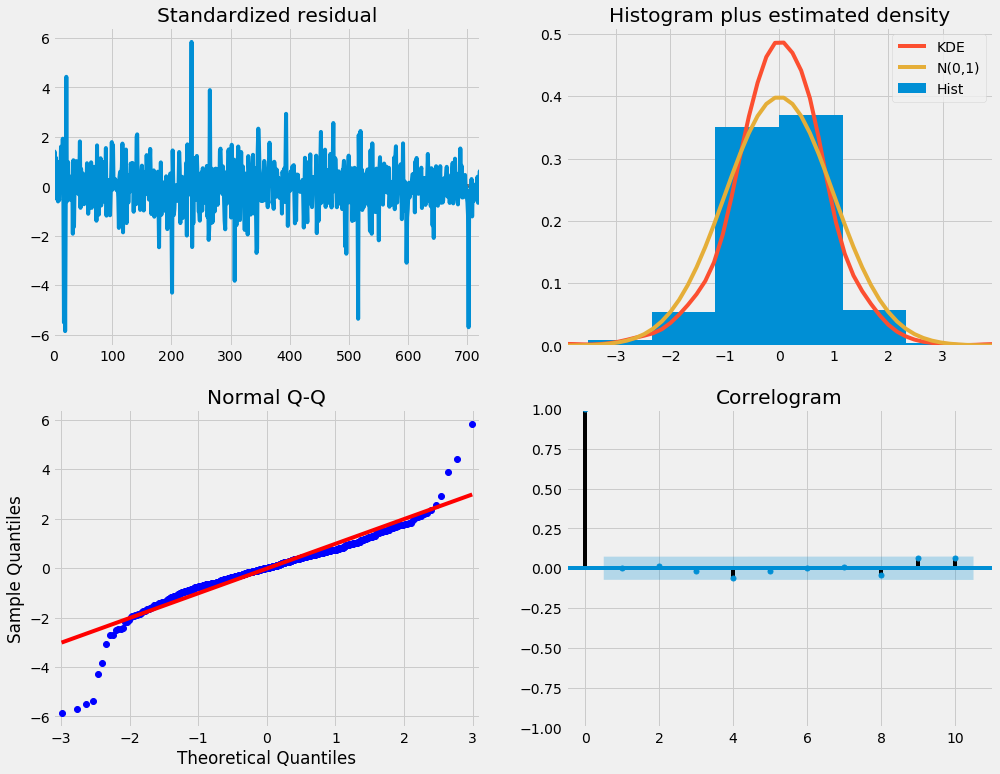

In [11]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

**The above plot shows that the residuals of our model are not normally distributed well. We should improve on our model. Our ultimate goal is to have uncorrelated residuals and normally distributed residuals.**

In [12]:
sarimax_preds = results.predict(start = results.nobs, 
                                end = results.nobs+19, 
                                exog=test.drop(columns='open_price'))

/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [13]:
results.nobs

733

/Users/jackwang/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


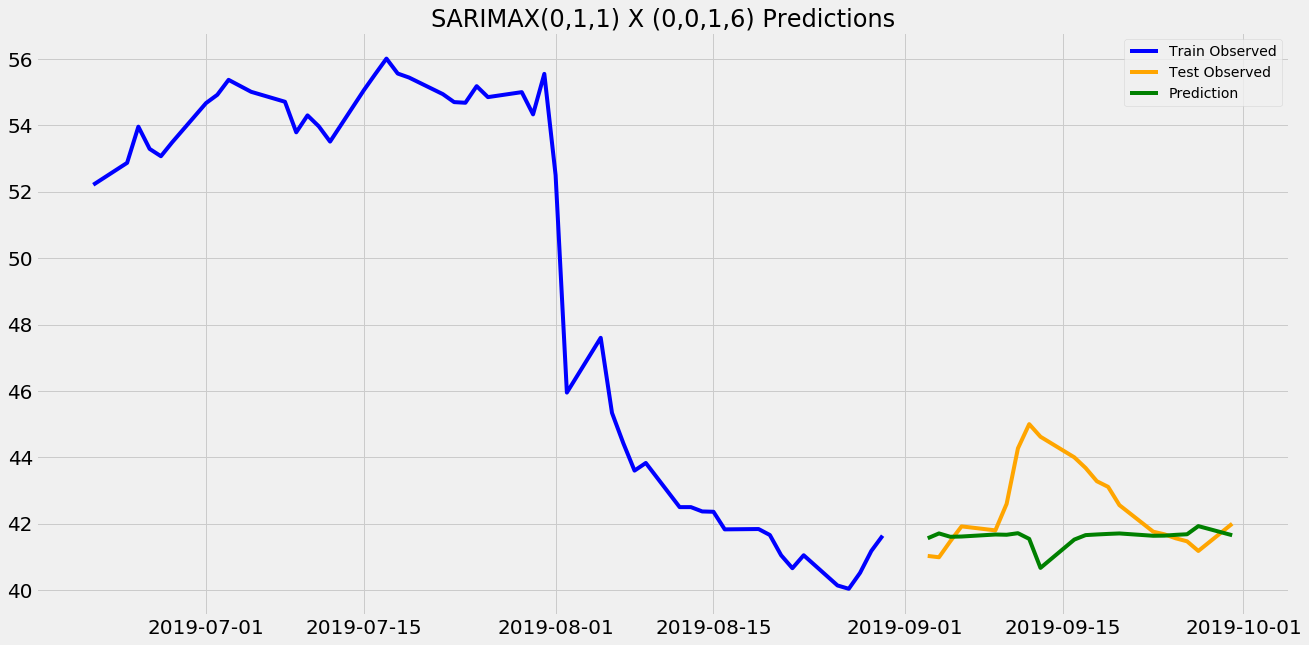

In [14]:
# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train.index[-50:], pd.DataFrame(train['open_price'][-50:]), color = 'blue')

# Plot testing data.
plt.plot(test.index, pd.DataFrame(test['open_price']), color = 'orange')

# Plot predicted test values.
plt.plot(test.index, pd.DataFrame(sarimax_preds), color = 'green')

# Set label.
plt.title(label = 'SARIMAX(0,1,1) X (0,0,1,6) Predictions', fontsize=24)

# Set legend.
plt.legend(['Train Observed', 'Test Observed', 'Prediction'])

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

In [15]:
# MSE
mean_squared_error(pd.DataFrame(test['open_price']), sarimax_preds)

2.608629717645921

### Dropping Low Correlation Features

In [16]:
train.corr()['open_price'].sort_values()

redd_pol_post_count         -0.214442
tweet_word_count_sum        -0.161478
redd_pol_score_sum          -0.151900
tweets_sum                  -0.151613
redd_gun_post_count         -0.113700
redd_pol_comment_sum        -0.110472
redd_gun_comment_sum        -0.082743
redd_gun_comment_mean       -0.080710
redd_gun_score_mean         -0.080237
redd_pol_score_mean         -0.059464
redd_gun_score_sum          -0.048888
10-k                        -0.032203
redd_pol_comment_mean       -0.026927
tweet_word_count_mean        0.002889
redd_pol_compound_mean       0.029383
10-q                         0.044495
8-k                          0.072419
redd_gun_compound_mean       0.081421
tweet_compound_score_sum     0.145399
tweet_compound_score_mean    0.197322
open_price                   1.000000
Name: open_price, dtype: float64

**Features can be dropped**
- 10-k                        -0.075070
- redd_gun_comment_sum        -0.034427
- redd_gun_comment_mean       -0.029288
- redd_pol_score_mean         -0.007994
- redd_pol_compound_mean      -0.004408
- redd_gun_score_sum          -0.003126
- redd_gun_score_mean          0.007457
- 10-q                         0.039278
- redd_pol_comment_mean        0.048663
- 8-k                          0.069770

In [17]:
dropping_list = ['10-k', 
                 'redd_gun_comment_sum',
                 'redd_gun_comment_mean',
                 'redd_pol_score_mean',
                 'redd_pol_compound_mean',
                 'redd_gun_score_sum',
                 'redd_gun_score_mean',
                 '10-q',
                 'redd_pol_comment_mean',
                 '8-k']

In [18]:
train_2 = train.drop(columns=dropping_list)

test_2 = test.drop(columns=dropping_list)

In [ ]:
best_aic = 10000
best_param = (0, 0, 0)
best_param_season = (0, 0, 0, 0)

for param in pdq:
    for param_seasonal in seasonal_pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_2['open_price'],
                                            train_2.drop(columns='open_price'),
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            current_aic = results.aic
            if current_aic < best_aic:
                best_aic = current_aic
                best_param = param
                best_param_season = param_seasonal
            print('ARIMA{}x{} - AIC: {}'.format(param, param_seasonal, results.aic))
        except:
            continue

print(f'Best AIC score is: {best_aic}')
print(f'ARIMA params is: {best_param}')
print(f'SARIMA param is: {best_param_season}')

/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC: 9204.618919443128


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 6) - AIC: 9204.618919443128


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 5) - AIC: 4905.175782031338


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 6) - AIC: 4889.538214804962
ARIMA(0, 0, 0)x(0, 1, 0, 5) - AIC: 7476.486668726906


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 0, 6) - AIC: 7584.823411633879


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 5) - AIC: 3397.8253275193474


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 6) - AIC: 3510.7788826689693


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 0, 5) - AIC: 4688.817250232033


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 0, 6) - AIC: 4692.891643109216


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 5) - AIC: 4696.646206605501


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 6) - AIC: 4714.4256415048685


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 1, 0, 5) - AIC: 3397.246100516589


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 0, 6) - AIC: 3508.136771644204


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 5) - AIC: 3399.818131708739


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [19]:
mod = sm.tsa.statespace.SARIMAX(endog=train_2['open_price'],
                                exog=train_2.drop(columns='open_price'),
                                order=(0, 1, 1),
                                seasonal_order=(0, 0, 1, 6),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                
Dep. Variable:                        open_price   No. Observations:                  733
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 6)   Log Likelihood               -1129.595
Date:                           Wed, 04 Dec 2019   AIC                           2285.191
Time:                                   16:09:32   BIC                           2344.793
Sample:                                        0   HQIC                          2308.195
                                           - 733                                         
Covariance Type:                             opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
tweet_word_count_sum       2.658e-07   1.27e-06      0.210      0.834   -2.22e-06    2.75e-0

/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


**As we can see, the p-value for all features are pretty high. We can conclude this model is performing poorly.**

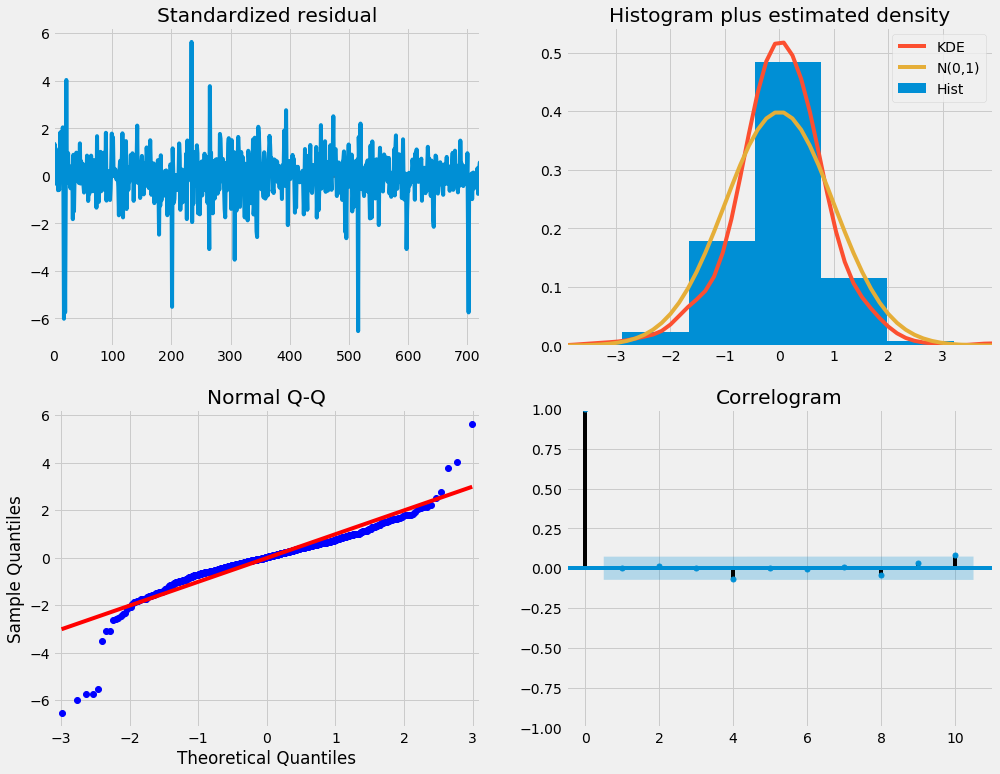

In [20]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

**The above plot shows that the residuals of our model are not normally distributed well. We should improve on our model. Our ultimate goal is to have uncorrelated residuals and normally distributed residuals.**

In [22]:
sarimax_preds_2 = results.predict(start = results.nobs, 
                               end = results.nobs+19, 
                               exog=test_2.drop(columns='open_price'),
                               dynamic=False)

/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


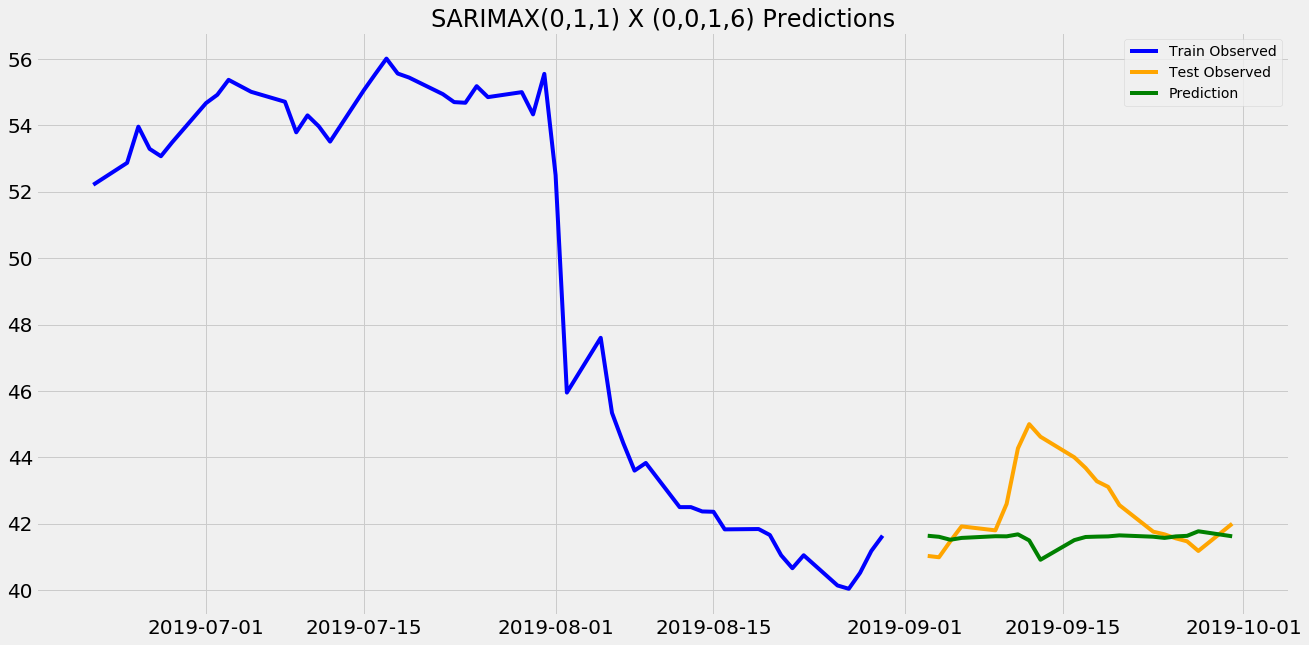

In [39]:
# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train_2.index[-50:], pd.DataFrame(train_2['open_price'][-50:]), color = 'blue')

# Plot testing data.
plt.plot(test_2.index, pd.DataFrame(test_2['open_price']), color = 'orange')

# Plot predicted test values.
plt.plot(test_2.index, pd.DataFrame(sarimax_preds_2), color = 'green')

# Set label.
plt.title(label = 'SARIMAX(0,1,1) X (0,0,1,6) Predictions', fontsize=24)

# Set legend.
plt.legend(['Train Observed', 'Test Observed', 'Prediction'])

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

In [26]:
# MSE
mean_squared_error(pd.DataFrame(test_2['open_price']), sarimax_preds_2)

2.5756278354362507

### Work on Percentage Difference

In [27]:
train_3 = df_final['2016':'2019-8'].copy()
test_3 = df_final['2019-9'].copy()

In [28]:
train_3['open_price'] = train_3['open_price'].pct_change()
test_3['open_price'] = test_3['open_price'].pct_change()

In [29]:
train_3.dropna(inplace=True)
test_3.dropna(inplace=True)

In [7]:
p = d = q = range(0, 2)
s = range(5,7)
pdq = list(itertools.product(p, d, q))
pdqs = list(itertools.product(p, d, q, s))
seasonal_pdqs = [(x[0], x[1], x[2], x[3]) for x in pdqs]

In [ ]:
best_aic = 10000
best_param = (0, 0, 0)
best_param_season = (0, 0, 0, 0)

for param in pdq:
    for param_seasonal in seasonal_pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_3['open_price'],
                                            train_3.drop(columns='open_price'),
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            current_aic = results.aic
            if current_aic < best_aic:
                best_aic = current_aic
                best_param = param
                best_param_season = param_seasonal
            print('ARIMA{}x{} - AIC: {}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [8]:
print(f'Best AIC score is: {best_aic}')
print(f'ARIMA params is: {best_param}')
print(f'SARIMA param is: {best_param_season}')

NameError: name 'best_aic' is not defined

In [31]:
mod = sm.tsa.statespace.SARIMAX(endog=train_3['open_price'],
                                exog=train_3.drop(columns='open_price'),
                                order=(0, 1, 1),
                                seasonal_order=(0, 0, 1, 6),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                
Dep. Variable:                        open_price   No. Observations:                  732
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 6)   Log Likelihood                1692.266
Date:                           Wed, 04 Dec 2019   AIC                          -3338.532
Time:                                   16:15:15   BIC                          -3233.114
Sample:                                        0   HQIC                         -3297.843
                                           - 732                                         
Covariance Type:                             opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
tweet_word_count_sum      -1.644e-09   2.85e-08     -0.058      0.954   -5.75e-08    5.42e-0

/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


**As we can see, the p-value for all features are pretty high. We can conclude this model is performing poorly.**

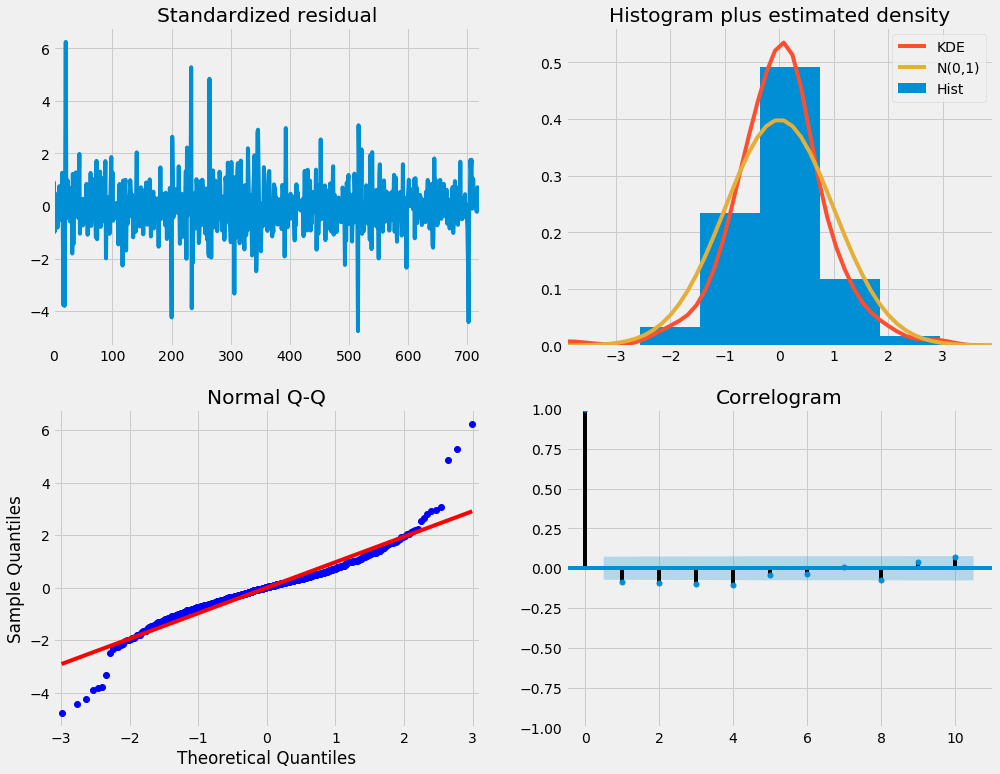

In [32]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

**The above plot shows that the residuals of our model are not normally distributed well. We should improve on our model. Our ultimate goal is to have uncorrelated residuals and normally distributed residuals.**

In [36]:
sarimax_preds_3 = results.predict(start = results.nobs, 
                                end = results.nobs+18, 
                                exog=test_3.drop(columns='open_price'))

/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [ ]:
test.index

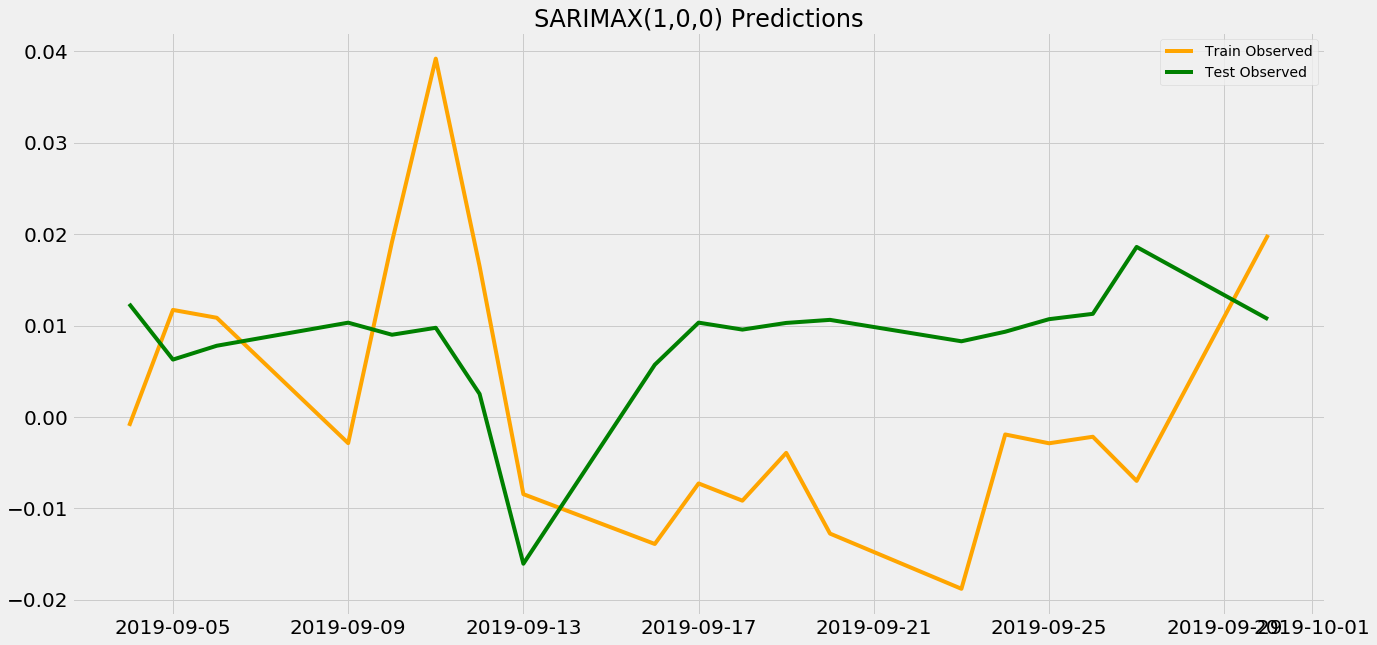

In [40]:
# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
#plt.plot(train.index, pd.DataFrame(train['open_price']), color = 'blue')

# Plot testing data.
plt.plot(test_3.index, pd.DataFrame(test_3['open_price']), color = 'orange')

# Plot predicted test values.
plt.plot(test_3.index, pd.DataFrame(sarimax_preds_3), color = 'green')

# Set label.
plt.title(label = 'SARIMAX(1,0,0) Predictions', fontsize=24)

# Set legend.
plt.legend(['Train Observed', 'Test Observed', 'Prediction'])

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

In [41]:
# MSE
mean_squared_error(pd.DataFrame(test_3['open_price']), sarimax_preds_3)

0.00028268797851903343

### Neural Network

In [43]:
df_final.head()

,open_price,tweet_word_count_sum,tweet_compound_score_sum,tweets_sum,tweet_word_count_mean,tweet_compound_score_mean,redd_gun_score_mean,redd_gun_comment_mean,redd_gun_compound_mean,redd_gun_score_sum,...,redd_gun_post_count,redd_pol_score_mean,redd_pol_comment_mean,redd_pol_compound_mean,redd_pol_score_sum,redd_pol_comment_sum,redd_pol_post_count,10-k,10-q,8-k
date,,,,,,,,,,,,,,,,,,,,,
2016-10-03,57.790001,18548,-401.5402,1133,16.370697,-0.354404,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-04,57.470001,16554,-356.2059,1017,16.277286,-0.350252,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-05,57.330002,19727,-338.7394,1194,16.521776,-0.283701,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-06,56.400002,12924,-220.6480,807,16.014870,-0.273418,0.0,7.0,-0.7184,0.0,...,1.0,2.0,5.0,-0.1958,4.0,10.0,2.0,0.0,0.0,0.0
2016-10-07,56.020000,9767,-210.2939,613,15.933116,-0.343057,1.0,1.0,-0.1280,1.0,...,1.0,0.0,3.0,0.3612,0.0,3.0,1.0,0.0,0.0,0.0


In [79]:
df = df_final.copy()

In [80]:
df['open_price'] = df['open_price'].pct_change()

In [81]:
df.dropna(inplace=True)

In [82]:
df['Target'] = (df['open_price'] >= 0).astype(int)

In [84]:
# Create X and y
X = df.drop(columns='Target')
y = df['Target'].values

In [85]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size=20)

In [86]:
# Scale
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train.drop(columns='open_price'))
X_test_sc = ss.transform(X_test.drop(columns='open_price'))

## `TimeseriesGenerator`
---

We'll now convert our data into series' using `TimeseriesGenerator`. The `length` parameter dictates how many rows will constitute a sample. The generator also creates our batches.

```python
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)
```

In the cells below, convert your training and validation data into sequences.

In [87]:
# Create training sequences
train_sequences = TimeseriesGenerator(X_train_sc, y_train,
                                      length = 3,
                                      batch_size = 128)

In [479]:
# Create test sequences
test_sequences = TimeseriesGenerator(X_test_sc, y_test,
                                     length = 3,
                                     batch_size = 128)

## Modeling time!
---

Now it's time to design our RNN model. We'll have:

- 2 `GRU` layers
- 2 hidden `Dense` layers
- 1 `Dense` output layer

We're doing a binary classification problem. As a result, our output layer needs to be 1 neuron, with the `sigmoid` activation function. This way, our model predicts a probability.

In [95]:
# Design RNN
model = Sequential()

# Don't set the activation fn for RNNs
model.add(GRU(20,
              dropout=.2, # X_sample
              recurrent_dropout=.2, # state from previous step
              input_shape=(3, 20), # implicitly setting the input layer
              return_sequences=True)) # True if the NEXT layer is RNNs

model.add(GRU(32,
              return_sequences=False)) # False if the NEXT layer is DENSE

# model.add(Dropout(.2)) # Bad after RNNs

model.add(Dense(64,
                activation='relu'))
model.add(Dropout(.2)) # good AFTER Dense


#
model.add(Dense(32,
                activation='relu'))
model.add(Dropout(.2)) # good AFTER Dense

#
# model.add(Dense(8,
#                 activation='relu'))
# model.add(Dropout(.2)) # good AFTER Dense


# For Binary classification
# 1 neuron, sigmoid activation fn
model.add(Dense(1,
                activation='sigmoid'))

In [96]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=.005),
              metrics=['accuracy'])

In [97]:
hist = model.fit_generator(train_sequences,
                    epochs=100,
                    validation_data=test_sequences,
                    verbose=2)

Epoch 1/100
6/6 - 1s - loss: 0.6938 - accuracy: 0.5007 - val_loss: 0.7148 - val_accuracy: 0.2353
Epoch 2/100
6/6 - 0s - loss: 0.6914 - accuracy: 0.4979 - val_loss: 0.7116 - val_accuracy: 0.2353
Epoch 3/100
6/6 - 0s - loss: 0.6931 - accuracy: 0.5158 - val_loss: 0.6925 - val_accuracy: 0.6471
Epoch 4/100
6/6 - 0s - loss: 0.6913 - accuracy: 0.5034 - val_loss: 0.6896 - val_accuracy: 0.6471
Epoch 5/100
6/6 - 0s - loss: 0.6884 - accuracy: 0.5446 - val_loss: 0.6715 - val_accuracy: 0.8235
Epoch 6/100
6/6 - 0s - loss: 0.6907 - accuracy: 0.5281 - val_loss: 0.6553 - val_accuracy: 0.8235
Epoch 7/100
6/6 - 1s - loss: 0.6860 - accuracy: 0.5377 - val_loss: 0.6672 - val_accuracy: 0.8824
Epoch 8/100
6/6 - 1s - loss: 0.6771 - accuracy: 0.5556 - val_loss: 0.6504 - val_accuracy: 0.8235
Epoch 9/100
6/6 - 1s - loss: 0.6804 - accuracy: 0.5322 - val_loss: 0.5988 - val_accuracy: 0.8235
Epoch 10/100
6/6 - 1s - loss: 0.6817 - accuracy: 0.5432 - val_loss: 0.5925 - val_accuracy: 0.8235
Epoch 11/100
6/6 - 1s - loss:

Epoch 85/100
6/6 - 0s - loss: 0.5110 - accuracy: 0.7023 - val_loss: 0.9785 - val_accuracy: 0.5294
Epoch 86/100
6/6 - 0s - loss: 0.4620 - accuracy: 0.7421 - val_loss: 1.0336 - val_accuracy: 0.4706
Epoch 87/100
6/6 - 0s - loss: 0.4688 - accuracy: 0.7353 - val_loss: 1.0522 - val_accuracy: 0.6471
Epoch 88/100
6/6 - 0s - loss: 0.4617 - accuracy: 0.7572 - val_loss: 0.9317 - val_accuracy: 0.7059
Epoch 89/100
6/6 - 0s - loss: 0.4601 - accuracy: 0.7545 - val_loss: 0.9357 - val_accuracy: 0.5882
Epoch 90/100
6/6 - 0s - loss: 0.4659 - accuracy: 0.7380 - val_loss: 0.8939 - val_accuracy: 0.6471
Epoch 91/100
6/6 - 0s - loss: 0.4663 - accuracy: 0.7449 - val_loss: 0.8961 - val_accuracy: 0.6471
Epoch 92/100
6/6 - 0s - loss: 0.4818 - accuracy: 0.7133 - val_loss: 0.7722 - val_accuracy: 0.6471
Epoch 93/100
6/6 - 0s - loss: 0.4272 - accuracy: 0.7750 - val_loss: 0.7101 - val_accuracy: 0.6471
Epoch 94/100
6/6 - 0s - loss: 0.4493 - accuracy: 0.7339 - val_loss: 0.7893 - val_accuracy: 0.7059
Epoch 95/100
6/6 - 0

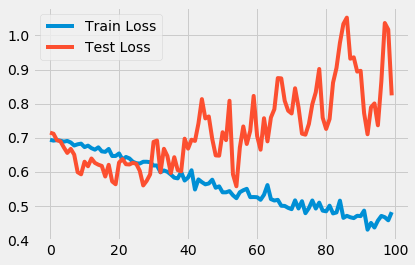

In [98]:
# Plot out our train/test loss curves

plt.plot(hist.history['loss'], label = "Train Loss")
plt.plot(hist.history['val_loss'], label = "Test Loss")
plt.legend();

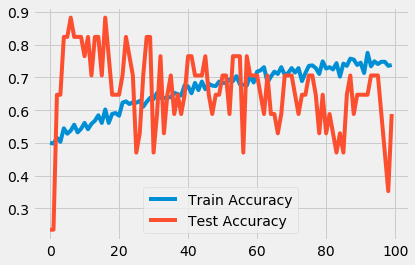

In [99]:
plt.plot(hist.history['accuracy'], label = "Train Accuracy")
plt.plot(hist.history['val_accuracy'], label = "Test Accuracy")
plt.legend();

In [ ]:
model.predict_classes(test_sequences[0][0])

In [ ]:
model.predict_proba(test_sequences[0][0])

### Regression

In [255]:
df = df_final.copy()

In [256]:
df['open_price'] = df['open_price'].pct_change()

In [257]:
df.dropna(inplace=True)

In [258]:
# Create X and y
X = df.drop(columns='open_price')
y = df['open_price'].values
y

array([-0.00553729, -0.00243604, -0.01622187, -0.00673762, -0.00571223,
        0.01974862, -0.01408449,  0.00892857,  0.0123894 ,  0.        ,
        0.02797199, -0.00680267,  0.02054788, -0.00335564,  0.01010098,
        0.01166668, -0.01070843, -0.00999164, -0.01093359,  0.00935372,
        0.03622581,  0.00406504,  0.00404858,  0.00887095,  0.03677057,
       -0.00462598, -0.10689389, -0.02775374, -0.11685993, -0.02828287,
        0.09979219, -0.00756147, -0.00285718,  0.02101247, -0.00187096,
       -0.00656041,  0.00188675, -0.0103578 , -0.00285437,  0.00858771,
        0.00946074, -0.03748829,  0.02044799, -0.03339695,  0.        ,
       -0.00197439, -0.0039565 ,  0.02383319,  0.00193992,  0.00774438,
       -0.00480307, -0.00579149,  0.00679608,  0.029894  , -0.00749067,
        0.01415094, -0.00651159,  0.00187262,  0.01121492, -0.00739366,
       -0.01582873, -0.00189211,  0.00284364,  0.01039696, -0.0056127 ,
        0.01787387,  0.00369688, -0.02209947, -0.0094162 , -0.01

In [259]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size=20)

In [260]:
# Scale
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

## `TimeseriesGenerator`
---

We'll now convert our data into series' using `TimeseriesGenerator`. The `length` parameter dictates how many rows will constitute a sample. The generator also creates our batches.

```python
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)
```

In the cells below, convert your training and validation data into sequences.

In [261]:
X_train.shape

(732, 20)

In [262]:
# Create training sequences
train_sequences = TimeseriesGenerator(X_train_sc, y_train,
                                      length = 3,
                                      batch_size = 128)

In [263]:
train_sequences[0][0].shape

(128, 3, 20)

In [264]:
# Create test sequences
test_sequences = TimeseriesGenerator(X_test_sc, y_test,
                                     length = 3,
                                     batch_size = 128)

In [265]:
test_sequences[0][0].shape

(17, 3, 20)

## Modeling time!
---

Now it's time to design our RNN model. We'll have:

- 2 `GRU` layers
- 2 hidden `Dense` layers
- 1 `Dense` output layer

We're doing a binary classification problem. As a result, our output layer needs to be 1 neuron, with the `sigmoid` activation function. This way, our model predicts a probability.

In [266]:
# Design RNN
model = Sequential()

# Don't set the activation fn for RNNs
model.add(GRU(21,
              dropout=.2, # X_sample
              recurrent_dropout=.2, # state from previous step
              input_shape=(3, 20), # implicitly setting the input layer
              return_sequences=True)) # True if the NEXT layer is RNNs

model.add(GRU(32,
              return_sequences=False)) # False if the NEXT layer is DENSE

# model.add(Dropout(.2)) # Bad after RNNs

model.add(Dense(64,
                activation='relu'))
model.add(Dropout(.2)) # good AFTER Dense


#
model.add(Dense(32,
                activation='relu'))
model.add(Dropout(.2)) # good AFTER Dense

#
model.add(Dense(8,
                activation='relu'))
model.add(Dropout(.2)) # good AFTER Dense


# For Binary classification
# 1 neuron, sigmoid activation fn
model.add(Dense(1,
                activation=None))

In [267]:
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=.005),
              metrics=['mean_squared_error'])

In [268]:
hist = model.fit_generator(train_sequences,
                    epochs=50,
                    validation_data=test_sequences,
                    verbose=2)

Epoch 1/50
6/6 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 3.3913e-04 - val_mean_squared_error: 3.3913e-04
Epoch 2/50
6/6 - 1s - loss: 5.8369e-04 - mean_squared_error: 5.8986e-04 - val_loss: 2.4301e-04 - val_mean_squared_error: 2.4301e-04
Epoch 3/50
6/6 - 1s - loss: 4.6921e-04 - mean_squared_error: 4.7132e-04 - val_loss: 2.2172e-04 - val_mean_squared_error: 2.2172e-04
Epoch 4/50
6/6 - 1s - loss: 4.7736e-04 - mean_squared_error: 4.8247e-04 - val_loss: 2.1802e-04 - val_mean_squared_error: 2.1802e-04
Epoch 5/50
6/6 - 1s - loss: 4.6721e-04 - mean_squared_error: 4.6844e-04 - val_loss: 2.2105e-04 - val_mean_squared_error: 2.2105e-04
Epoch 6/50
6/6 - 1s - loss: 4.5556e-04 - mean_squared_error: 4.5773e-04 - val_loss: 2.1762e-04 - val_mean_squared_error: 2.1762e-04
Epoch 7/50
6/6 - 1s - loss: 4.5615e-04 - mean_squared_error: 4.5837e-04 - val_loss: 2.2022e-04 - val_mean_squared_error: 2.2022e-04
Epoch 8/50
6/6 - 1s - loss: 4.8349e-04 - mean_squared_error: 4.8674e-04 - val_loss: 

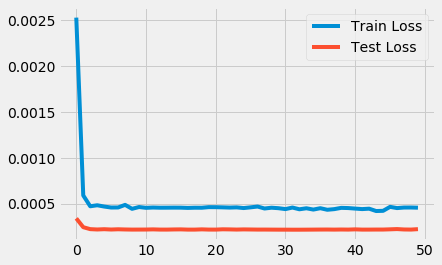

In [269]:
# Plot out our train/test loss curves

plt.plot(hist.history['loss'], label = "Train Loss")
plt.plot(hist.history['val_loss'], label = "Test Loss")
plt.legend();

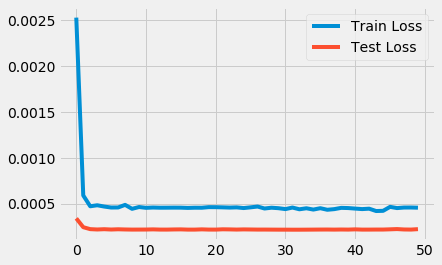

In [270]:
plt.plot(hist.history['mean_squared_error'], label = "Train Loss")
plt.plot(hist.history['val_mean_squared_error'], label = "Test Loss")
plt.legend();

In [271]:
preds = model.predict(test_sequences[0][0])

In [272]:
preds

array([[-0.0013864],
       [-0.0013864],
       [-0.0013864],
       [-0.0013864],
       [-0.0013864],
       [-0.0013864],
       [-0.0013864],
       [-0.0013864],
       [-0.0013864],
       [-0.0013864],
       [-0.0013864],
       [-0.0013864],
       [-0.0013864],
       [-0.0013864],
       [-0.0013864],
       [-0.0013864],
       [-0.0013864]], dtype=float32)

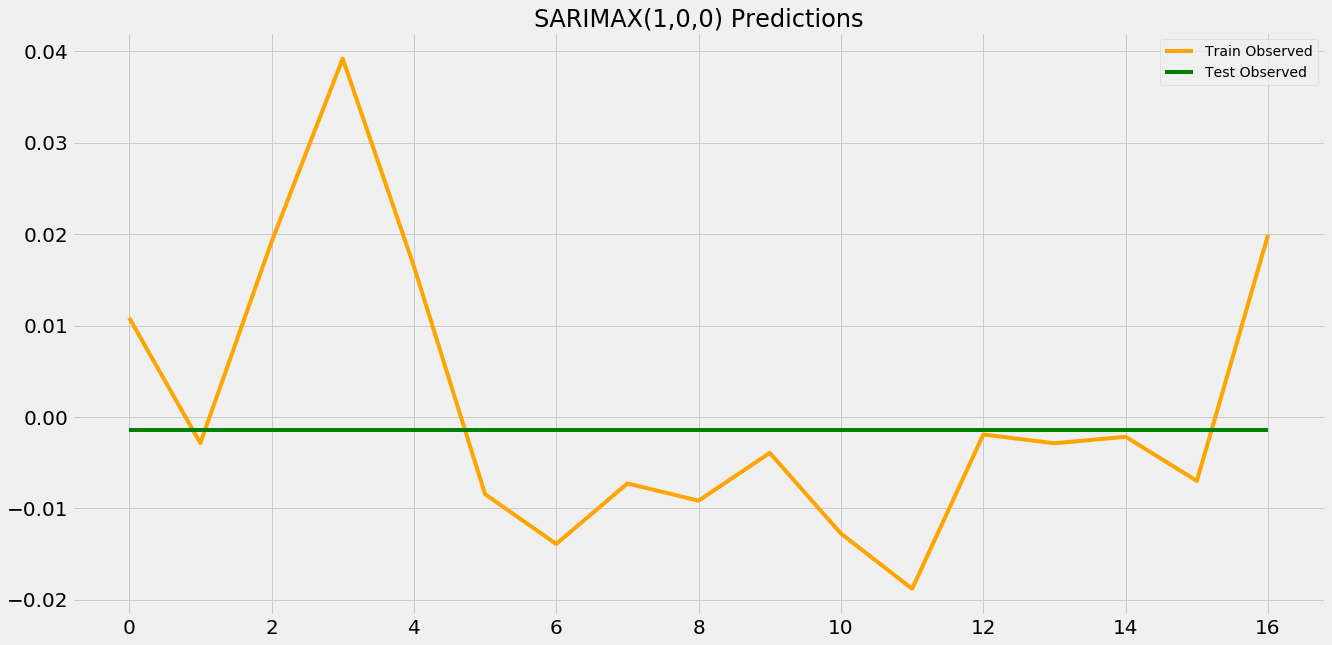

In [273]:
# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
#plt.plot(train.index, pd.DataFrame(train['open_price']), color = 'blue')

# Plot testing data.
plt.plot(pd.DataFrame(y_test[3:]).index, pd.DataFrame(y_test[3:]), color = 'orange')

# Plot predicted test values.
plt.plot(pd.DataFrame(preds).index, pd.DataFrame(preds), color = 'green')

# Set label.
plt.title(label = 'SARIMAX(1,0,0) Predictions', fontsize=24)

# Set legend.
plt.legend(['Train Observed', 'Test Observed', 'Prediction'])

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

### Model for Pickle

In [435]:
df = df_final.copy().iloc[:,0:6]

In [436]:
df['open_price'] = df['open_price'].pct_change()

In [437]:
df.dropna(inplace=True)

In [438]:
df['Target'] = (df['open_price'] >= 0).astype(int)

In [439]:
# Create X and y
X = df.drop(columns='Target')
y = df['Target'].values

In [440]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size=23)

In [441]:
# Scale
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train.drop(columns='open_price'))
X_test_sc = ss.transform(X_test.drop(columns='open_price'))

In [463]:
scaler_file = "my_scaler.save"
joblib.dump(ss, "../assets/scaler.save")

['../assets/scaler.save']

In [465]:
scaler = joblib.load("../assets/scaler.save") 

In [467]:
scaler.transform(X_test.drop(columns='open_price'))

array([[-0.0820351 ,  0.11040498, -0.10579633,  0.87093378,  0.07815265],
       [-0.12486733,  0.15637282, -0.14480464,  0.83059397,  0.61655328],
       [-0.13199435,  0.14879379, -0.14989711,  0.78742182,  0.04262577],
       [ 1.03255811, -0.93060226,  0.87603147,  1.18807165, -1.28927527],
       [ 1.04180627, -0.84121224,  0.87246674,  1.24070903, -0.59788209],
       [ 0.38911196, -0.26195295,  0.31066569,  1.10799904,  0.03457651],
       [ 0.13479311, -0.08271969,  0.07814361,  1.13070842, -0.60800973],
       [ 0.11532291, -0.05065831,  0.07814361,  0.91079515,  0.12634747],
       [ 0.20558008, -0.1564846 ,  0.17337275,  0.8102086 , -0.28301928],
       [ 0.37162272, -0.35175978,  0.3490629 ,  0.69290204, -0.74751033],
       [ 0.53173725, -0.43195553,  0.47219877,  0.8987042 , -0.27673319],
       [ 0.83741346, -0.58692537,  0.73649785,  1.0134867 ,  0.53024076],
       [ 0.2194763 , -0.13639479,  0.1577898 ,  1.0974415 , -0.17285054],
       [ 0.06324253, -0.02040074,  0.0

## `TimeseriesGenerator`
---

We'll now convert our data into series' using `TimeseriesGenerator`. The `length` parameter dictates how many rows will constitute a sample. The generator also creates our batches.

```python
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)
```

In the cells below, convert your training and validation data into sequences.

In [442]:
# Create training sequences
train_sequences = TimeseriesGenerator(X_train_sc, y_train,
                                      length = 2,
                                      batch_size = 128)

In [443]:
# Create test sequences
test_sequences = TimeseriesGenerator(X_test_sc, y_test,
                                     length = 2,
                                     batch_size = 128)

## Modeling time!
---

Now it's time to design our RNN model. We'll have:

- 2 `GRU` layers
- 2 hidden `Dense` layers
- 1 `Dense` output layer

We're doing a binary classification problem. As a result, our output layer needs to be 1 neuron, with the `sigmoid` activation function. This way, our model predicts a probability.

In [447]:
# Design RNN
model = Sequential()

# Don't set the activation fn for RNNs
model.add(GRU(5,
              dropout=.2, # X_sample
              recurrent_dropout=.2, # state from previous step
              input_shape=(2, 5), # implicitly setting the input layer
              return_sequences=True)) # True if the NEXT layer is RNNs

model.add(GRU(32,
              return_sequences=False)) # False if the NEXT layer is DENSE

# model.add(Dropout(.2)) # Bad after RNNs

model.add(Dense(64,
                activation='relu'))
model.add(Dropout(.2)) # good AFTER Dense

#
model.add(Dense(32,
                activation='relu'))
model.add(Dropout(.2)) # good AFTER Dense

# For Binary classification
# 1 neuron, sigmoid activation fn
model.add(Dense(1,
                activation='sigmoid'))

In [448]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=.005),
              metrics=['accuracy'])

In [449]:
hist = model.fit_generator(train_sequences,
                    epochs=50,
                    validation_data=test_sequences,
                    verbose=2)

Epoch 1/50
6/6 - 1s - loss: 0.6933 - accuracy: 0.5089 - val_loss: 0.6931 - val_accuracy: 0.4762
Epoch 2/50
6/6 - 1s - loss: 0.6925 - accuracy: 0.4938 - val_loss: 0.6983 - val_accuracy: 0.3333
Epoch 3/50
6/6 - 0s - loss: 0.6925 - accuracy: 0.5062 - val_loss: 0.7093 - val_accuracy: 0.3333
Epoch 4/50
6/6 - 0s - loss: 0.6928 - accuracy: 0.5282 - val_loss: 0.7084 - val_accuracy: 0.3333
Epoch 5/50
6/6 - 1s - loss: 0.6918 - accuracy: 0.5186 - val_loss: 0.7024 - val_accuracy: 0.3333
Epoch 6/50
6/6 - 1s - loss: 0.6933 - accuracy: 0.4979 - val_loss: 0.6957 - val_accuracy: 0.3333
Epoch 7/50
6/6 - 1s - loss: 0.6929 - accuracy: 0.5034 - val_loss: 0.7034 - val_accuracy: 0.3333
Epoch 8/50
6/6 - 1s - loss: 0.6891 - accuracy: 0.5296 - val_loss: 0.7041 - val_accuracy: 0.3333
Epoch 9/50
6/6 - 0s - loss: 0.6909 - accuracy: 0.5131 - val_loss: 0.7036 - val_accuracy: 0.3333
Epoch 10/50
6/6 - 0s - loss: 0.6914 - accuracy: 0.5309 - val_loss: 0.7058 - val_accuracy: 0.3333
Epoch 11/50
6/6 - 0s - loss: 0.6927 - a

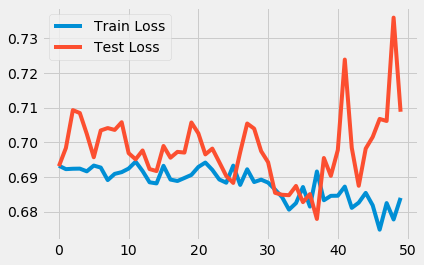

In [450]:
# Plot out our train/test loss curves

plt.plot(hist.history['loss'], label = "Train Loss")
plt.plot(hist.history['val_loss'], label = "Test Loss")
plt.legend();

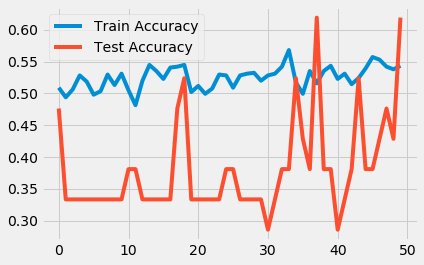

In [451]:
plt.plot(hist.history['accuracy'], label = "Train Accuracy")
plt.plot(hist.history['val_accuracy'], label = "Test Accuracy")
plt.legend();

In [452]:
model.predict_classes(test_sequences[0][0])

array([[0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1]], dtype=int32)

In [453]:
model

In [454]:
model.predict_proba(test_sequences[0][0])

array([[0.47981483],
       [0.46879503],
       [0.31328568],
       [0.40369925],
       [0.91728485],
       [0.5101555 ],
       [0.49666795],
       [0.49231082],
       [0.45356435],
       [0.43579447],
       [0.480549  ],
       [0.8557567 ],
       [0.4885963 ],
       [0.4867517 ],
       [0.50919974],
       [0.49822867],
       [0.48965654],
       [0.49194333],
       [0.47709796],
       [0.4775442 ],
       [0.50369537]], dtype=float32)

In [455]:
model.save('../assets/final_model.h5')

In [456]:
model = load_model('../assets/final_model.h5')

In [457]:
model.predict_classes(test_sequences[0][0])

array([[0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1]], dtype=int32)

In [ ]:
test_sequences = TimeseriesGenerator(X_test_sc, [],
                                     length = 2,
                                     batch_size = 128)

**Check our work**

Let's read in our model and check the score/coefficients.
- `pickle.load(file)`: de-serializes the stored object back into a variable

In [8]:
# use the above function with open() and 'read binary' permissions to get our model back
model_from_pickle = pickle.load(open('../Files/final_model.p', 'rb'))

In [9]:
print(model_from_pickle.score(X_test['tweet'], y_test))

0.6746987951807228


In [10]:
model_from_pickle.predict_proba(["power outage is happening, so is blackouts weather is so bad"])

array([[0.64965368, 0.35034632]])

**Testing our model:**

In [11]:
some_tweet = ['This tweet could be a aggregation of all tweets on twitter mentioniing about blackouts']
print(model_from_pickle.predict(some_tweet))
print(model_from_pickle.predict_proba(some_tweet))

[1]
[[0.4 0.6]]
